# Radio Frequency Interference: Identifying Nearby Sources

In the world of radio astronomy, observations of signals from extraterrestrial origins are often compounded by human-made sources. Many electronical sources, such as radio stations, cell phone towers, WiFi, even GPS satellites and your personal microwave oven, can interfere with radio astronomy. This tutorial combines usage of hardware with some code to identify nearby interference sources. This analysis is part of the larger practice of filtering out any human-made and Earth-based radio signals to better identify potential signals of interest from space.

For my experiment, I used a Realtek RTL2838 dongle as my hardware receiver. While I specifically looked for nearby radio stations within the limited scope of the hardware, the code can be applied with little modification, depending on the hardware used, to processing and identifying a wide range of other sources.

Ultimately, this script produces two outputs:
   1. A plot showing signal sources as peaks, which are marked according to a given dictionary of the sources' names. The plot is a spectrum of signal power against frequency
   2. A dictionary matching the peaking frequencies with their sources
Familiarizing with the properties of human-made sources can be convenient for manually dismissing uninteresting signals.

# From the Command Line: rtl_power

Before diving into python code, we first need to generate a file to store in the data from the dongle. The command to do that is rtl_power:

rtl_power -f min:max:bin filename.ext

min: initial frequency
max: terminal frequency
bin: frequency interval

The file extension I used is csv. There are additional parameters for further options; example:

rtl_power -f 87M:108M:1k -g 20 -i 10 -e 5m logfile.csv

Here, I set the gain to 20 and the runtime to 15 minutes, taking data in 10-second intervals. All the data is stored in a csv file logfile.csv. With our data in hand, open a python file with your favorite editor and begin the processing.

# Modules to Import and Global Variables

Several modules are important for the basic functioning of this script:
   1. Numpy: essential for computing and number crunching
   2. Matplotlib.pyplot: useful for plotting
   3. csv: used to generate the raw data, which is stored as a csv file, into a workable text file. The appropriate modules, depending on the format of the raw data file and the format of the desired data conversion, should be used here
   4. OrderedDict from collections: outputs any dictionary with the entries in the order that you entered them. This will be useful later for ordering peaks, but is useful in general when dealing with dictionaries

I've written a short helper function that allows you to calculate differences between times since python works primarily in date times. This is just a kludge and will not work if you take measurements that cross into different days. In that case I recommend you just manually enter the information associated with time.

In [173]:
def calc_time_diff(time1, time2):
    """returns difference in seconds between time 1 and time 2
    
    time1, time2: strings in format hh:mm:ss
    """
    str_to_sec = lambda time: sum([60**p[0]*int(p[1]) for p in enumerate(time.split(":")[::-1])])
    return str_to_sec(time1) - str_to_sec(time2)

In [174]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import datetime
from collections import OrderedDict
from FMstations import *

df = pd.read_csv("logfile.csv", header=None)
MINFREQ = min(df[2])
MAXFREQ = max(df[3])
FREQ_BIN = df[4][0]
LINES_PER_TIME = len(df[2].unique())
INTERVAL = calc_time_diff(df[1][LINES_PER_TIME],  df[1][0]) 
TOTAL_TIME = INTERVAL * len(df) / LINES_PER_TIME
raw_data = df.as_matrix()[:,6:].astype("float") # raw_data is 2d numpy matrix of only data 

Next block visualizes the data 

In [175]:
df

,0,1,2,3,4,5,6,7,8,9,...,4093,4094,4095,4096,4097,4098,4099,4100,4101,4102
0,2017-06-06,23:37:56,87000000,89625000,640.87,38,-38.30,-38.79,-41.36,-43.17,...,-43.24,-42.61,-44.77,-44.45,-44.14,-43.04,-41.17,-41.48,-39.93,-39.93
1,2017-06-06,23:37:56,89625000,92250000,640.87,38,-54.37,-54.05,-54.31,-53.87,...,-53.81,-54.70,-53.27,-54.74,-54.87,-52.55,-55.16,-54.15,-53.03,-53.03
2,2017-06-06,23:37:56,92250000,94875000,640.87,38,-26.20,-27.49,-26.28,-25.18,...,-27.29,-25.72,-25.18,-25.13,-24.68,-26.88,-26.90,-25.86,-25.32,-25.32
3,2017-06-06,23:37:56,94875000,97500000,640.87,38,-24.49,-24.49,-26.52,-24.42,...,-26.36,-25.51,-25.74,-24.25,-25.64,-25.83,-26.34,-24.86,-24.75,-24.75
4,2017-06-06,23:37:56,97500000,100125000,640.87,38,-45.73,-46.96,-46.99,-47.61,...,-39.60,-40.42,-40.14,-41.01,-39.80,-39.93,-40.43,-43.06,-46.69,-46.69
5,2017-06-06,23:37:56,100125000,102750000,640.87,38,-43.66,-43.66,-44.71,-45.50,...,-45.53,-44.84,-45.65,-44.36,-43.89,-44.75,-43.63,-45.13,-44.36,-44.36
6,2017-06-06,23:37:56,102750000,105375000,640.87,38,-36.64,-38.51,-37.75,-38.68,...,-31.87,-33.95,-33.42,-35.14,-36.16,-34.54,-38.21,-37.41,-37.39,-37.39
7,2017-06-06,23:37:56,105375000,108000000,640.87,38,-34.65,-35.35,-33.13,-32.52,...,-31.74,-31.14,-33.02,-33.45,-34.10,-31.73,-34.13,-33.57,-32.00,-32.00
8,2017-06-06,23:38:06,87000000,89625000,640.87,38,-39.97,-42.29,-42.55,-44.17,...,-46.91,-45.58,-46.07,-46.15,-44.70,-45.01,-42.43,-41.25,-41.04,-41.04
9,2017-06-06,23:38:06,89625000,92250000,640.87,38,-55.40,-55.50,-54.43,-54.56,...,-54.83,-54.33,-53.78,-55.15,-55.41,-54.71,-55.26,-55.32,-54.64,-54.64


FMstations is a separate .py file storing a dictionary to be used in a later function. While dictionaries can be included in the executing script without functional issues, their potential large size warrants storage in a separate file.

logfile.csv is the file containing the raw data, an array of lines. Each line is an array itself, consisting of a number of power values corresponding to the sampling rate. Specifically for my experiment, the sampling rate is 2.5 MHz and each eight lines constitute a scan of the bandwidth of interest, the 21 MHz band between 87 and 108 MHz. U.S. radio stations are allocated broadcast frequencies in that range, and these values should be changed according to the experiment at hand. Data is collected every 10 seconds for every 610.35 (raw_data[0][4]) frequency difference in that range over a total of 300 seconds. 

The raw data file consists of 240 lines because the scan is performed 30 times, the total number of seconds divided by the scan interval. Each line unfortunately comes with an initial six outputs, such the date of when the data was taken, that we have no interest of for purposes of data processing and plotting. Those outputs would have to be truncated.

## Processing Raw Data

First, we have to idenfity the frequency range we are interested in nd have it be consistent with the type and number of data in the file for plotting by generating a list of frequencies between our min and max frequencies that correspond to the amount of samples we have for each time step

In [176]:
def total_freq(num_samples_per_time):
    """total frequency band of the data

    num_samples_per_time: number of data samples over entire frequency spectrum per timestep
    """
    return np.linspace(MINFREQ, MAXFREQ, num_samples_per_time)

TotalBand = total_freq(len(raw_data[0]) * LINES_PER_TIME)

There are many ways to go about processing the raw data values to correspond with our frequency range. Since my data came in the form of an array of arrays, that's how I initially kept my data as, though with the fir several unneeded elements truncated from each line. The follow code does just that.

In [177]:
def power_total(data):
    """returns an array of arrays that is flattened from the original array such that each row consists of the
    entire frequency range instead of chunks

    data: input raw data; an array of arrays
    """
    flattened = []
    cur = []
    for i in range(len(data)):
        cur += list(raw_data[i])
        if (i+1)%LINES_PER_TIME == 0:
            flattened.append(cur)
            cur = []
    return np.array(flattened)
total_data = power_total(raw_data)

Unlike the raw data, however, each inner array now consists of a full scan of the relevant band (as opposed to each line in the raw data corresponding to only an eighth of the band). For my data, there's now only 30 inner arrays, each a scan at a specific time, down from 240 lines in the raw data.

Having this result is useful for, as an example, plotting multiple graphs to see the time-evolution of the signal. For our immediate purposes, we look at the time-averaged values to produce a single plot.

We now take the average across time of all these arrays

In [178]:
avg_data = np.mean(total_data, axis=0)



We now have a single array of values ripe for plotting.

## Spectrum Improvement and Plotting

Let's see a visual of our plot of the average power values against our frequency band.

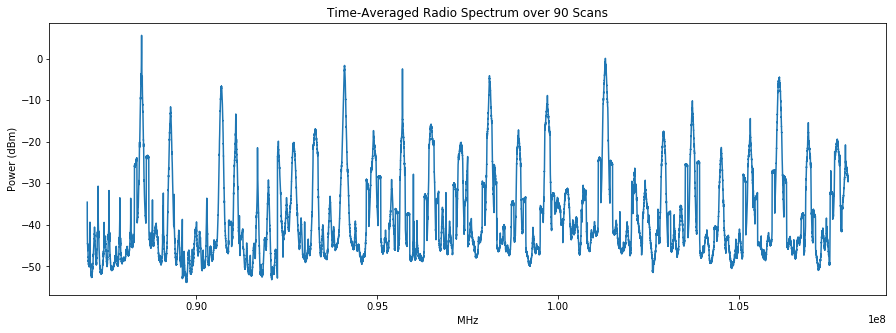

In [179]:
plt.figure(figsize=(15,5))
plt.title('Time-Averaged Radio Spectrum over 90 Scans')
plt.xlabel('MHz')
plt.ylabel('Power (dBm)')
plt.plot(TotalBand, avg_data)
plt.show()

We have a functional plot, but it's riddled with issues associated with signal process. We need to  remove the noisy peaks and smooth out the graph so that we can systematically identify the peaks, which correspond to frequencies which signals are received at. Power is in units of dBm, decibels referencing milliwatts. Online resources have more in-depth explanation of the bel unit and power representation in signal processing.

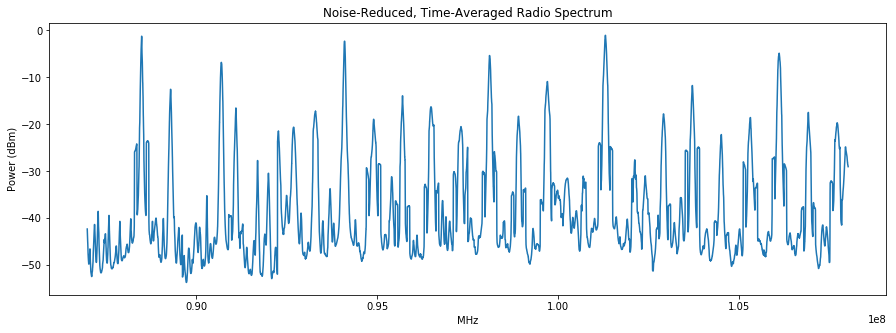

In [180]:
def Reduce(spec, n):
    """takes the median of a set of points, removing noise-produced peaks and much noise
    
    n: half the number of a set of points that the median is taken over
    """
    R = []
    i = 0
    for x in spec:
        if i < n:
            R.append(np.median(spec[0 : i + n + 1]))
            i += 1
        elif i >= 32769:
            R.append(np.median(spec[i - n :]))
            i += 1
        else:
            R.append(np.median(spec[i - n : i + n + 1]))
            i += 1
    return R

ReduSpec = Reduce(avg_data, 10)

plt.figure(figsize=(15,5))
plt.title('Noise-Reduced, Time-Averaged Radio Spectrum')
plt.xlabel('MHz')
plt.ylabel('Power (dBm)')
plt.plot(TotalBand, ReduSpec)
plt.show()

This is seemingly our desired plot, but upon closer inspection...

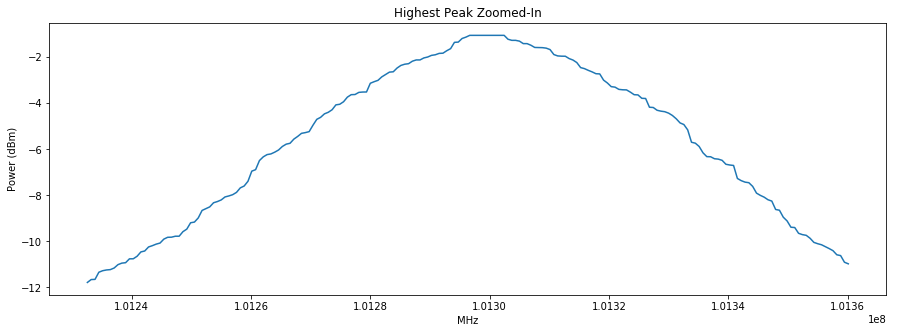

In [181]:
plt.figure(figsize=(15,5))
plt.title('Highest Peak Zoomed-In')
plt.xlabel('MHz')
plt.ylabel('Power (dBm)')
highest_peak_loc = np.argmax(ReduSpec)
plt.plot(TotalBand[highest_peak_loc-100:highest_peak_loc+100], ReduSpec[highest_peak_loc-100:highest_peak_loc+100])
plt.show()

Despite the plot looking great from afar, it's still rather rugged even at the peaks upon closer inspection. The roughness can make it difficult to mathematically identify peaks. What we need is a smoothing. The process of smoothing a function over another (convolution) is rooted in mathematical rigor, so we do not go in depth there. Essentially, a smoothing function, traditionally called the kernel, is 'applied' and moved along our spectrum. There are various ways to implement convolution and thankfully numpy has built-in function to make the job simpler.

In [182]:
def smooth(spec, win_len, window, beta = 20):
    """smooths a signal with kernel window of win_len number of inputs
    
    signal: Input data spectrum to be smoothed
    win_len: the size of the kernel window used to smooth the input
    window: type of kernel; e.g. 'blackman'
    """
    if window == 'kaiser':
        w = eval('np.'+window+'(win_len, beta)')
    elif window == 'flat':
        w = np.ones(len(win_len, 'd'))
    else:
        w = eval('np.'+window+'(win_len)')
    s = np.r_[spec[win_len-1 : 0 : -1], spec, spec[-1 : -win_len : -1]]
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[(int(win_len / 2) - 1) : (int(-win_len / 2))]

The code evaluates based on what type of smoothing we're using. Numpy has a number of built-in smoothing functions. For my plots, I used the kaiser kernel, which is derived from Bessel functions. If flat smoothing is chosen, then our plot is smoothed by a line. The result is a much smoother graph, with the side effect of reduced power at every point.

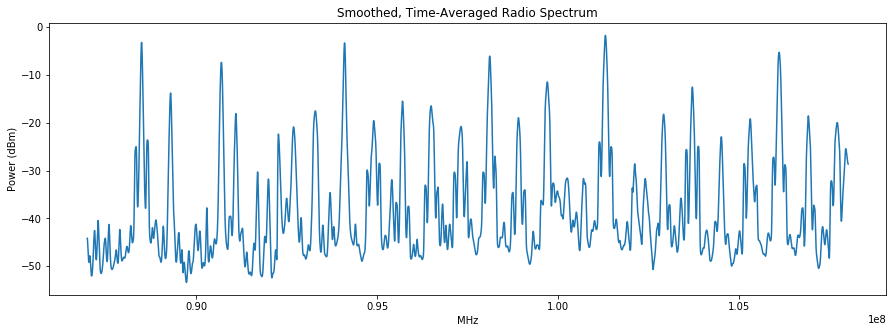

In [183]:
SmooSpec = smooth(ReduSpec, 150, 'kaiser')

plt.figure(figsize=(15,5))
plt.title('Smoothed, Time-Averaged Radio Spectrum')
plt.xlabel('MHz')
plt.ylabel('Power (dBm)')
plt.plot(TotalBand, SmooSpec)
plt.show() 

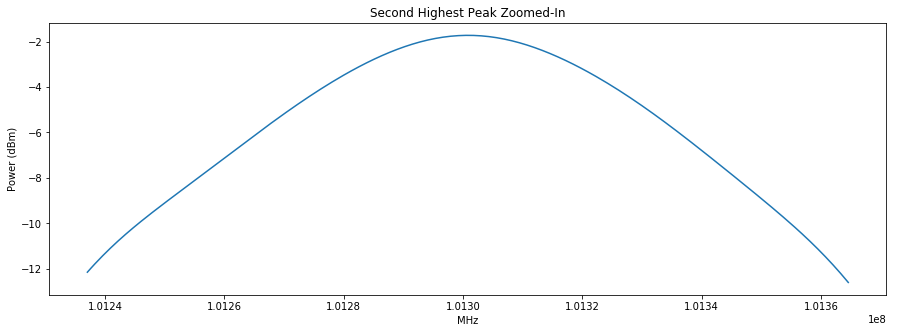

In [184]:
plt.figure(figsize=(15,5))
plt.title('Second Highest Peak Zoomed-In')
plt.xlabel('MHz')
plt.ylabel('Power (dBm)')
highest_peak_loc = np.argmax(SmooSpec)
plt.plot(TotalBand[highest_peak_loc-100:highest_peak_loc+100], SmooSpec[highest_peak_loc-100:highest_peak_loc+100])
plt.show()

We finally have our smoothed plot and can systematically identify characteristics with numpy without dealing with much of the interference due to rough data patterns. 

## Identifying and Marking Peaks and their Frequencies

We can isolate the peak frequencies with simple methods.

In [185]:
def get_peaks(spec, threshold, xreducer, rounder=2):
    """identifies the peaks of a plot. Returns an array of 2 lists:

    1. the indices of the frequencies corresponding to the peaks;
    2. said frequencies, divided by xreducer for simpler units and rounded to rounder decimals
   
    spec: input data spectrum
    threshold: only data above which are taken into account to ignore the noise level
    """
    Peaks = []
    spec = spec.tolist()
    for i in np.arange(len(spec)):
        if spec[i] > threshold and spec[i] > spec[i-1] and spec[i] > spec[i+1]:
            Peaks.append(spec[i])
        else:
            continue
    Ordered_Indices = []
    while True:
        if np.array(Peaks).tolist() == []:
            Ordered_Freq = [(x * FREQ_BIN + MINFREQ) for x in Ordered_Indices]
            Reduced_Freq = np.around((np.array(Ordered_Freq) / xreducer), rounder)
            return [Ordered_Indices, Reduced_Freq.tolist()]
        elif len(Peaks) == 1:
            Ordered_Indices.append(spec.index(Peaks[0]))
            Peaks = np.delete(Peaks, 0)   
        else:
            Ordered_Indices.append(spec.index(np.amax(Peaks)))
            Peaks = np.delete(Peaks, np.array(Peaks).tolist().index(np.amax(Peaks)))

THe function iterates over all the values in the spectrum and stores any frequency (and its associated index) of the peaks (values above a certain threshold that's a local maxima) in arrays. The indices will be useful for corresponding the frequencies with their peak location. The majority of the function is ordering the frequencies in descending order of the peak intensity by iterating over the array of peaks and determining each's corresponding peak value. The ordered list is then rounded to one decimal and is in units of MHz or in a desired unit as determined by xreducer.

With a list of peaks, we can use them to physically mark their sources on our plot, provided a dictionary of the sources.

In [186]:
def mark_peaks(src_dict, spec, threshold, line, title, xreducer, error=.01, bound1='left', bound2='bottom', rot=90):
    """returns both a plot and a dictionary
    
    plot: shows the stations next to the marked peaks
    dictionary: matches the relevant peak frequencies with the corresponding station(s)
    
    src_dict: input dictionary of frequencies and stations from which the results are selected from
    spec: input spectrum data
    threshold: only data above which are taken in account to ignore the noise level
    title: title for the plot
    xreducer: the values of the x-axis divided by which to simpler units
    error: within which the obtained frequencies are acceptable as equivalent to that of a station
    remaining parameters: used the adjust the markings and labels of the plots
    """
    stations = []
    peakfreqs = []
    stations_i = []
    peaker = get_peaks(spec, threshold, xreducer)
    p0 = peaker[0]
    p1 = peaker[1]
    for i in np.arange(len(p1)):
        if p1[i] in src_dict.keys():
            stations.append(src_dict[p1[i]])
            peakfreqs.append(p1[i])
            stations_i.append(p0[i])
        else:
            for x in np.arange(p1[i]-error, p1[i]+error, error):
                if x in src_dict.keys():
                    stations.append(src_dict[x])
                    peakfreqs.append(p1[i])
                    stations_i.append(p0[i])
                else:
                    continue
    peaks = [spec[y] for y in stations_i]
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Reduced Power (dBm)')
    yoffset = (np.amax(spec) - np.amin(spec)) / 4
    plt.ylim(np.amin(spec) - yoffset, np.amax(spec) + yoffset)
    plt.plot(TotalBand / 1000000, spec)
    plt.scatter(peakfreqs, peaks, marker = 'o', color = 'r', s = 40)
    text_bounds = {'ha':bound1, 'va':bound2}
    for i in np.arange(len(peakfreqs)):
        plt.text(peakfreqs[i], peaks[i] + (yoffset / 10), stations[i], text_bounds, rotation=rot)
    plt.savefig('stations_peaks.pdf')
    plt.show()
    stations_dict = OrderedDict()
    for i in np.arange(len(stations)):
        stations_dict[peakfreqs[i]] = stations[i]
    return stations_dict

It's a rather long function, but a lot of it is making adjustments to the final plot. The function requires an input [ython dictionary, so that dictionary either has to be from an established source online or be manually made. For my code, I made a dictionary of all Bay Area FM Radio Stations (BAFMRS) with their corresponding frequencies as the dictionary keys. For example, an entry in the dictionary is '88.5: KQED' with 88.5 MHz being the transmitting frequency and KQED being the name of the station. 

A radio station signal comes in the form of a primary analog signal (almost all the peaks you see on the plot) and two digital signals on the side; only the stronger signals, such as the one corresponding to the leftmost peak, visibly show the digital parts. This function naturally filters out almost all digital peaks because their frequencies do not correspond to any of that in a dictionary of radio station signals. Unfortunately, it's not easy to feasibly filter multiple stations broadcasting the same frequency with this level of coding. Naturally, however, there won't be many of these cases at any given location.

The final plot, all processed and labeled:

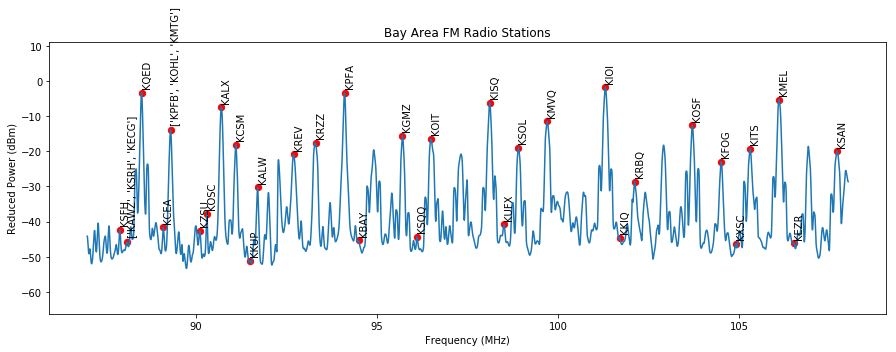

OrderedDict([(101.3, 'KIOI'), (88.5, 'KQED'), (94.1, 'KPFA'), (106.1, 'KMEL'), (98.11, 'KISQ'), (90.7, 'KALX'), (99.7, 'KMVQ'), (103.7, 'KOSF'), (89.3, ['KPFB', 'KOHL', 'KMTG']), (95.7, 'KGMZ'), (96.49, 'KOIT'), (93.3, 'KRZZ'), (91.1, 'KCSM'), (98.9, 'KSOL'), (105.3, 'KITS'), (107.7, 'KSAN'), (92.7, 'KREV'), (104.5, 'KFOG'), (102.11, 'KRBQ'), (91.7, 'KALW'), (90.3, 'KOSC'), (98.51, 'KUFX'), (89.1, 'KCEA'), (87.9, 'KSFH'), (90.11, 'KZSU'), (96.1, 'KSQQ'), (101.7, 'KKIQ'), (94.49, 'KBAY'), (88.1, ['KAWZ', 'KSRH', 'KECG']), (106.5, 'KEZR'), (104.9, 'KXSC'), (91.5, 'KKUP')])


In [187]:
print(mark_peaks(BAFMRS, SmooSpec, -54, 8, 'Bay Area FM Radio Stations', 1000000)) 

We got our final result. This particular approach is useful for identifying nearby signal sources for any purpose. Another approach uses not the average power values, but all the power values from all the scans. Visualizing the time-evolution can be useful for other purposes, such as noting the fluctuations of the peaks' strengths or finding sudden peaks arising at certain moments. The "waterfall" plot displays, in this case, intensity (power) with color codes and has time instead on the y-axis.

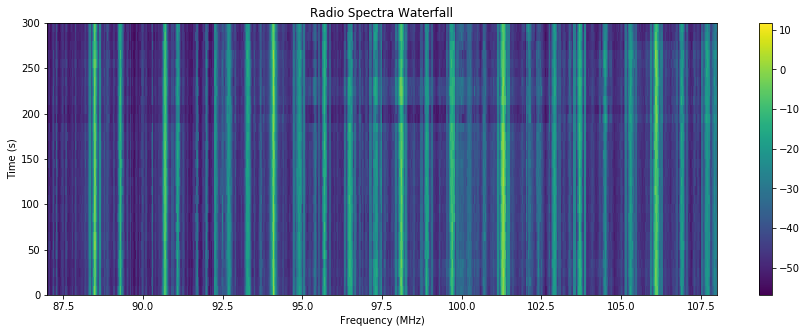

In [188]:
def waterfall(data, title, axesrange, gridshape='auto'):
    """returns a waterfall grid consisting off all the spectra from the input 

    data: an array of arrays
    title: title of grid
    axesrange: boundaries of the values of the grid
    """
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Time (s)')
    plt.imshow(data, extent=axesrange)
    ax.set_aspect(gridshape)
    plt.colorbar(orientation='vertical')
    plt.show()

waterfall(total_data, 'Radio Spectra Waterfall', [MINFREQ*1e-6, MAXFREQ*1e-6, 0, TOTAL_TIME])

This function plots the unprocessed total data. In this function we could run our signal processing functions on each time step, however for the pruposes of data visualization, it is often better to plot the original data. Processing was done to make it easier to find the peaks algorithmically.